In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 한글폰트 설정 (실행 후 런타임 다시 시작하고 다시 실행하면 한글폰트 적용 가능) -> colab 기준, jupyter 사용시 문의바람
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [ ]:
total_df = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/new_data/W_total.csv')
total_df

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395884,395884,20180101211409,코나,9066e4eaf0847da687522158d39a212d,충북 청주시 청원구,810000,1,0,35.0,35.0,NaN,35.0,27.0,27.0
395885,395885,20180101174328,스포티지QL,53813806d052950f7838d65a1c810dee,광주시 서구 상무대로,410000,1,0,31.0,31.0,NaN,31.0,37.0,NaN
395886,395886,20180101141541,GLE,75951c44e1785f1a8b38bbe0ac306a3f,대전시 유성구 복용동,590000,1,0,23.0,27.0,NaN,27.0,NaN,NaN
395887,395887,20180101140030,티볼리,52251649fb0a77f0a0b0bb57f37d1473,대전시 유성구 관들1길,580000,1,0,35.0,35.0,NaN,35.0,150.0,NaN


In [ ]:
# 차 이름 - 모델 매칭 테이블 불러오기
name = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/name_to_model(full).csv')
name.head()

,Unnamed: 0,name,model,maker,prefix,postfix
0,0,렉스턴,렉스턴,쌍용,0,0
1,1,K7,K7,기아,0,0
2,2,투싼,투싼,현대,0,0
3,3,기아 4세대 카니발 KA4,카니발,기아,0,0
4,4,QM6,QM6,르노삼성,0,0


In [ ]:
# 차 이름 - 모델 매칭 테이블과 조인
total_df = total_df.merge(name[['name', 'model', 'maker']], left_on = 'car', right_on = 'name', how = 'left')
total_df.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0,렉스턴,렉스턴,쌍용
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,K7,K7,기아
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN,투싼,투싼,현대
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN,QM6,QM6,르노삼성


In [ ]:
# 상품번호 - 상품명 매칭 테이블 가져오기 및 조인
product = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/product.csv')
product = product.rename(columns = {'name' : 'product_name'})
total_df_item = total_df.copy()
for i in range(1, 7):
  total_df_item = total_df_item.merge(product[['product', 'product_name']], left_on = 'product_%d'%i, right_on = 'product', how = 'left')
  total_df_item = total_df_item.rename(columns = {'product_name' : 'product_%d_name' % i})
  total_df_item = total_df_item.drop(columns = ['product'])
total_df_item.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker,product_1_name,product_2_name,product_3_name,product_4_name,product_5_name,product_6_name
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0,렉스턴,렉스턴,쌍용,Pinnacle,Pinnacle,Pinnacle,Pinnacle,Pinnacle,Pinnacle
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,K7,K7,기아,Star,Star,NaN,Star,Star,NaN
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN,투싼,투싼,현대,Super,Super,Super,Super,Super,NaN
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아,Star,Star,NaN,Star,Star,NaN
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN,QM6,QM6,르노삼성,Super,Super,NaN,Super,Super,NaN


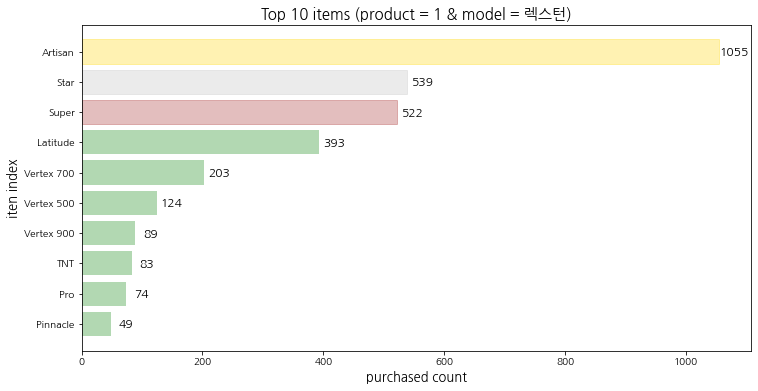

In [ ]:
# EDA 예시 : 아이템 위치와 차량 모델명을 input으로 넣으면 top 10 시공이 많이된 아이템을 뽑는 예시

def EDA_item_model(location, model_name): # 다른 조건을 추가하고 싶다면 파라미터를 추가하면 됨

  # top 10 뽑는 과정 (조건 변경 가능) # product_%d_name 대신 product_%d 도 사용 가능 (int -> string 처리를 해주어야 함에 주의)
  item_rank = total_df_item.loc[total_df_item.model == model_name, 'product_%d_name' %location].value_counts().iloc[:10].iloc[::-1]

  # 시각화 코드
  plt.figure(figsize = (12, 6))
  bar = plt.barh(item_rank.index, item_rank, color='green', alpha = 0.3)

  # 그래프 옆에 숫자 표시
  for rect in bar:
      width = rect.get_width()
      plt.text(width + 25, rect.get_y() + rect.get_height()/4.0, '%d' %width, ha='center', va='bottom', size = 12)

  # 금은동 색칠
  bar[-1].set_color(c = 'gold')
  bar[-2].set_color(c = 'silver')
  bar[-3].set_color(c = 'brown')

  # 제목, 축 이름
  plt.title('Top 10 items (product = %d & model = %s)' % (location, model_name), size = 15)
  plt.xlabel('purchased count', size = 13)
  plt.ylabel('item index', size = 13)
  plt.show()

EDA_item_model(1, '렉스턴')

count       253.000000
mean     521501.976285
std       60906.813059
min      160000.000000
25%      520000.000000
50%      520000.000000
75%      550000.000000
max      710000.000000
Name: price, dtype: float64


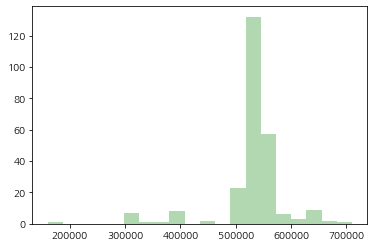

In [ ]:
# EDA 예시 : 조건 설정시 가격 분포 추출 (사용법 : Notion 내 Brainstorming 문서 참조)

def Price_Dist(df, model, store, dealer, product):
  condition_1 = True; condition_2 = True; condition_3 = True; condition_4 = True
  if model: condition_1 = df['model'] == model
  if store: condition_2 = df['store'] == store
  if (dealer == 0) | (dealer == 1): condition_3 = df['by_dealer'] == dealer
  if product:
    for i in range(6):
      if product[i]:
        col = 'product_%d' % (i + 1) # 이 부분 'product_%d_name'으로 바꾸면 item name을 기준으로 검색 가능
        condition_4 = (condition_4) & (df[col] == product[i])
  prices = df.loc[(condition_1) & (condition_2) & (condition_3) & (condition_4), 'price']
  # prices = prices.loc[prices < prices.quantile(0.95)] # 상위 5% 이상치 제거 가능 (숫자 변경 가능)
  print(prices.describe())
  plt.hist(prices, bins = 20, color = 'green', alpha = 0.3)
  plt.show()

Price_Dist(total_df_item, '투싼', None, 0, [284, None, None, None, None, None])

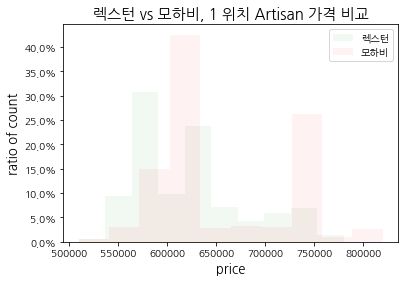

In [ ]:
# EDA 예시 : 두 차종의 특정 위치, 특정 상품의 가격분포 비교 (ex : 렉스턴 vs 모하비, 1번 위치에 Artisan이 시공된 경우에 대해서 보고 싶을 때)
# 다만, 다른 위치의 상품은 따로 고려해두지는 않았음

from matplotlib.ticker import PercentFormatter

def Compare_Price(df, car1, car2, location, item_name):
  car1_price = df.loc[(df['model'] == car1) & (df['product_%d_name' % location] == item_name), 'price'] # product_%d 로 item number 대신 사용 가능
  car2_price = df.loc[(df['model'] == car2) & (df['product_%d_name' % location] == item_name), 'price']
  car1_price = car1_price.loc[(car1_price < car1_price.quantile(0.95)) & (car1_price > car1_price.quantile(0.05))] # 상, 하위 5%는 제거
  car2_price = car2_price.loc[(car2_price < car2_price.quantile(0.95)) & (car2_price > car2_price.quantile(0.05))] # (숫자 변경 가능)
  plt.hist(car1_price, bins = 10, color = 'green', alpha = 0.05, label = '%s' % car1,\
          weights=np.ones(len(car1_price)) / len(car1_price)) # 전체 수 대비 차지하는 비율로 바꿔줌
  plt.hist(car2_price, bins = 10, color = 'red', alpha = 0.05, label = '%s' % car2,\
        weights=np.ones(len(car2_price)) / len(car2_price))
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  plt.title('%s vs %s, %d 위치 %s 가격 비교' % (car1, car2, location, item_name), size = 15)
  plt.xlabel('price', size = 13)
  plt.ylabel('ratio of count', size = 13)
  plt.legend()
  plt.show()
Compare_Price(total_df_item, '렉스턴', '모하비', 1, 'Artisan')